## Generador de Prediccion Estandar

In [76]:
#Se limpia la memoria
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2404562,128.5,4767548,254.7,4767548,254.7
Vcells,4108769,31.4,179629085,1370.5,224448902,1712.5


In [77]:
semilla <- 100019
set.seed(semilla)

In [78]:
#cargo las librerias que necesito
require("data.table")
require("rpart")
require("rpart.plot")
#Contiene funciones para evaluar performance de la clasificación
library("ROCR")

library("caret")
library("ranger")

In [79]:
setwd("C:/_MCD/Labo1/code")  #Establezco el Working Directory

In [80]:
dataset  <- fread("./datasets/competencia1_2022.csv")

In [81]:
dtrain  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar
dapply  <- dataset[ foto_mes==202103 ]  #defino donde voy a aplicar el modelo

In [82]:
modelo  <- rpart(formula=    "clase_ternaria ~ .", #quiero predecir clase_ternaria a partir de el resto de las variables
                 data =      dtrain,  #los datos donde voy a entrenar
                 xval=       0,
             cp=           -0.5,
                 minsplit=    1340,
                 minbucket=   600,
                 maxdepth=      6   )


Ahora grafico el arbol, va a ser muy frondoso porque la profundidad es de 10

In [83]:
#prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0)

Ahora aplico al modelo  a los datos muevos  y genero la salida para kaggle

aplico el modelo a los datos nuevos

In [84]:
prediccion  <- predict( modelo, dapply , type = "prob") #aplico el modelo

prediccion es una matriz con TRES columnas, llamadas "BAJA+1", "BAJA+2"  y "CONTINUA"
cada columna es el vector de probabilidades 

agrego a dapply una columna nueva que es la probabilidad de BAJA+2

In [85]:
dapply[ , prob_baja2 := prediccion[, "BAJA+2"] ]

solo le envio estimulo a los registros con probabilidad de BAJA+2 mayor  a  1/40

In [86]:
head(dapply)

numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,⋯,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,clase_ternaria,prob_baja2
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>
31115668,202103,1,0,0,56,134,688.41,26701.84,98.82,⋯,0,-16247.77,0,4056,15732.34,1,0,1137.81,,0.0003144439
31115678,202103,1,0,0,48,102,78.43,24418.75,-73.62,⋯,NA,NA,NA,NA,NA,NA,NA,NA,,0.0003144439
31117415,202103,1,0,0,60,55,8101.55,3162.23,13399.50,⋯,0,-31103.23,0,1632,2860.54,2,0,19858.89,,0.0033441208
31117711,202103,1,0,0,46,275,14825.78,138050.05,1146.27,⋯,0,-13733.44,0,2122,1419.36,3,0,1231.65,,0.0003144439
31118145,202103,1,0,0,47,194,2015.61,31240.49,1791.25,⋯,0,0.00,0,5901,1286.93,1,0,82.11,,0.0047378395
31118204,202103,1,0,0,68,260,14424.33,71750.45,3694.07,⋯,0,-55168.01,0,3180,35363.16,18,0,5114.28,,0.0033441208


In [87]:
nrow(dapply)

[1] 162900

In [88]:
dapply[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]

In [89]:
fwrite( dapply[,list(numero_de_cliente, Predicted)],
        file= "normal.csv", 
        sep= "," )

creo la carpeta donde va el experimento

In [90]:
#dir.create( "./exp/competencia1" ) 

Hago lo mismo con train para evaluar en entrenamiento

In [91]:
prediccion  <- predict( modelo, dtrain , type = "prob") #aplico el modelo
dtrain[ , prob_baja2 := prediccion[, "BAJA+2"] ]
dtrain[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]

### Curva ROC

In [92]:
dtrain[, clase := 0]
dtrain[ clase_ternaria=='BAJA+2' ,   clase:= 1]

In [93]:
#Calculo las metricas
pred <- prediction(dtrain$Predicted, dtrain$clase)

#Calculo las metricas
perf <- performance(pred, measure = "tpr", x.measure = "fpr")

#Grafico la ROC
#plot(perf, col=rainbow(10))

#Determino AUC
#performance( pred,"auc")@y.values

### Ganancia

In [94]:
#Ganancia por TP
kTPGain               <-  78000

#Pérdida por FP
kFPGain               <-  -2000

#Calculo la ganancia
dtrain[  , ganancia:= kFPGain ] #-1250
dtrain[ clase_ternaria=='BAJA+2' ,   ganancia:= kTPGain] #48750
sum( dtrain$ganancia )

gan <- sum( dtrain[ dtrain$Predicted==1, ganancia] )

#TP
truepositive <- sum(dtrain$Predicted*dtrain[,clase])

#Incentivados Totales
incentivados <- sum(dtrain$Predicted)

print(paste("La Ganancia es:", gan))
print(paste("TP:", truepositive))
print(paste("Incentivados:",incentivados))

[1] -254684000

[1] "La Ganancia es: 22880000"
[1] "TP: 463"
[1] "Incentivados: 7080"


grabo el dataset

In [95]:
nombre_archivo_salida <- "./exp/competencia1/cv8_E1001_rpart_kaggle_00004_pred.csv"

In [96]:
fwrite( dapply[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
        file= nombre_archivo_salida, 
        sep= "," )

In [97]:
options(scipen=999)

In [98]:
modelo

n= 161342 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 161342 1514 CONTINUA (0.0041154814 0.0052683120 0.9906162066)  
    2) ctrx_quarter< 13.5 8400  711 CONTINUA (0.0347619048 0.0498809524 0.9153571429)  
      4) mcuentas_saldo< -1256.1 2928  416 CONTINUA (0.0618169399 0.0802595628 0.8579234973)  
        8) cprestamos_personales< 1.5 2328  396 CONTINUA (0.0743127148 0.0957903780 0.8298969072)  
         16) ctrx_quarter< 5.5 1362  278 CONTINUA (0.0837004405 0.1204111601 0.7958883994)  
           32) mactivos_margen< 121.6 600  152 CONTINUA (0.1233333333 0.1300000000 0.7466666667) *
           33) mactivos_margen>=121.6 762  126 CONTINUA (0.0524934383 0.1128608924 0.8346456693) *
         17) ctrx_quarter>=5.5 966  118 CONTINUA (0.0610766046 0.0610766046 0.8778467909) *
        9) cprestamos_personales>=1.5 600   20 CONTINUA (0.0133333333 0.0200000000 0.9666666667) *
      5) mcuentas_saldo>=-1256.1 5472  295 CONTINUA (0.0202850877 0.0336257310 0.

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


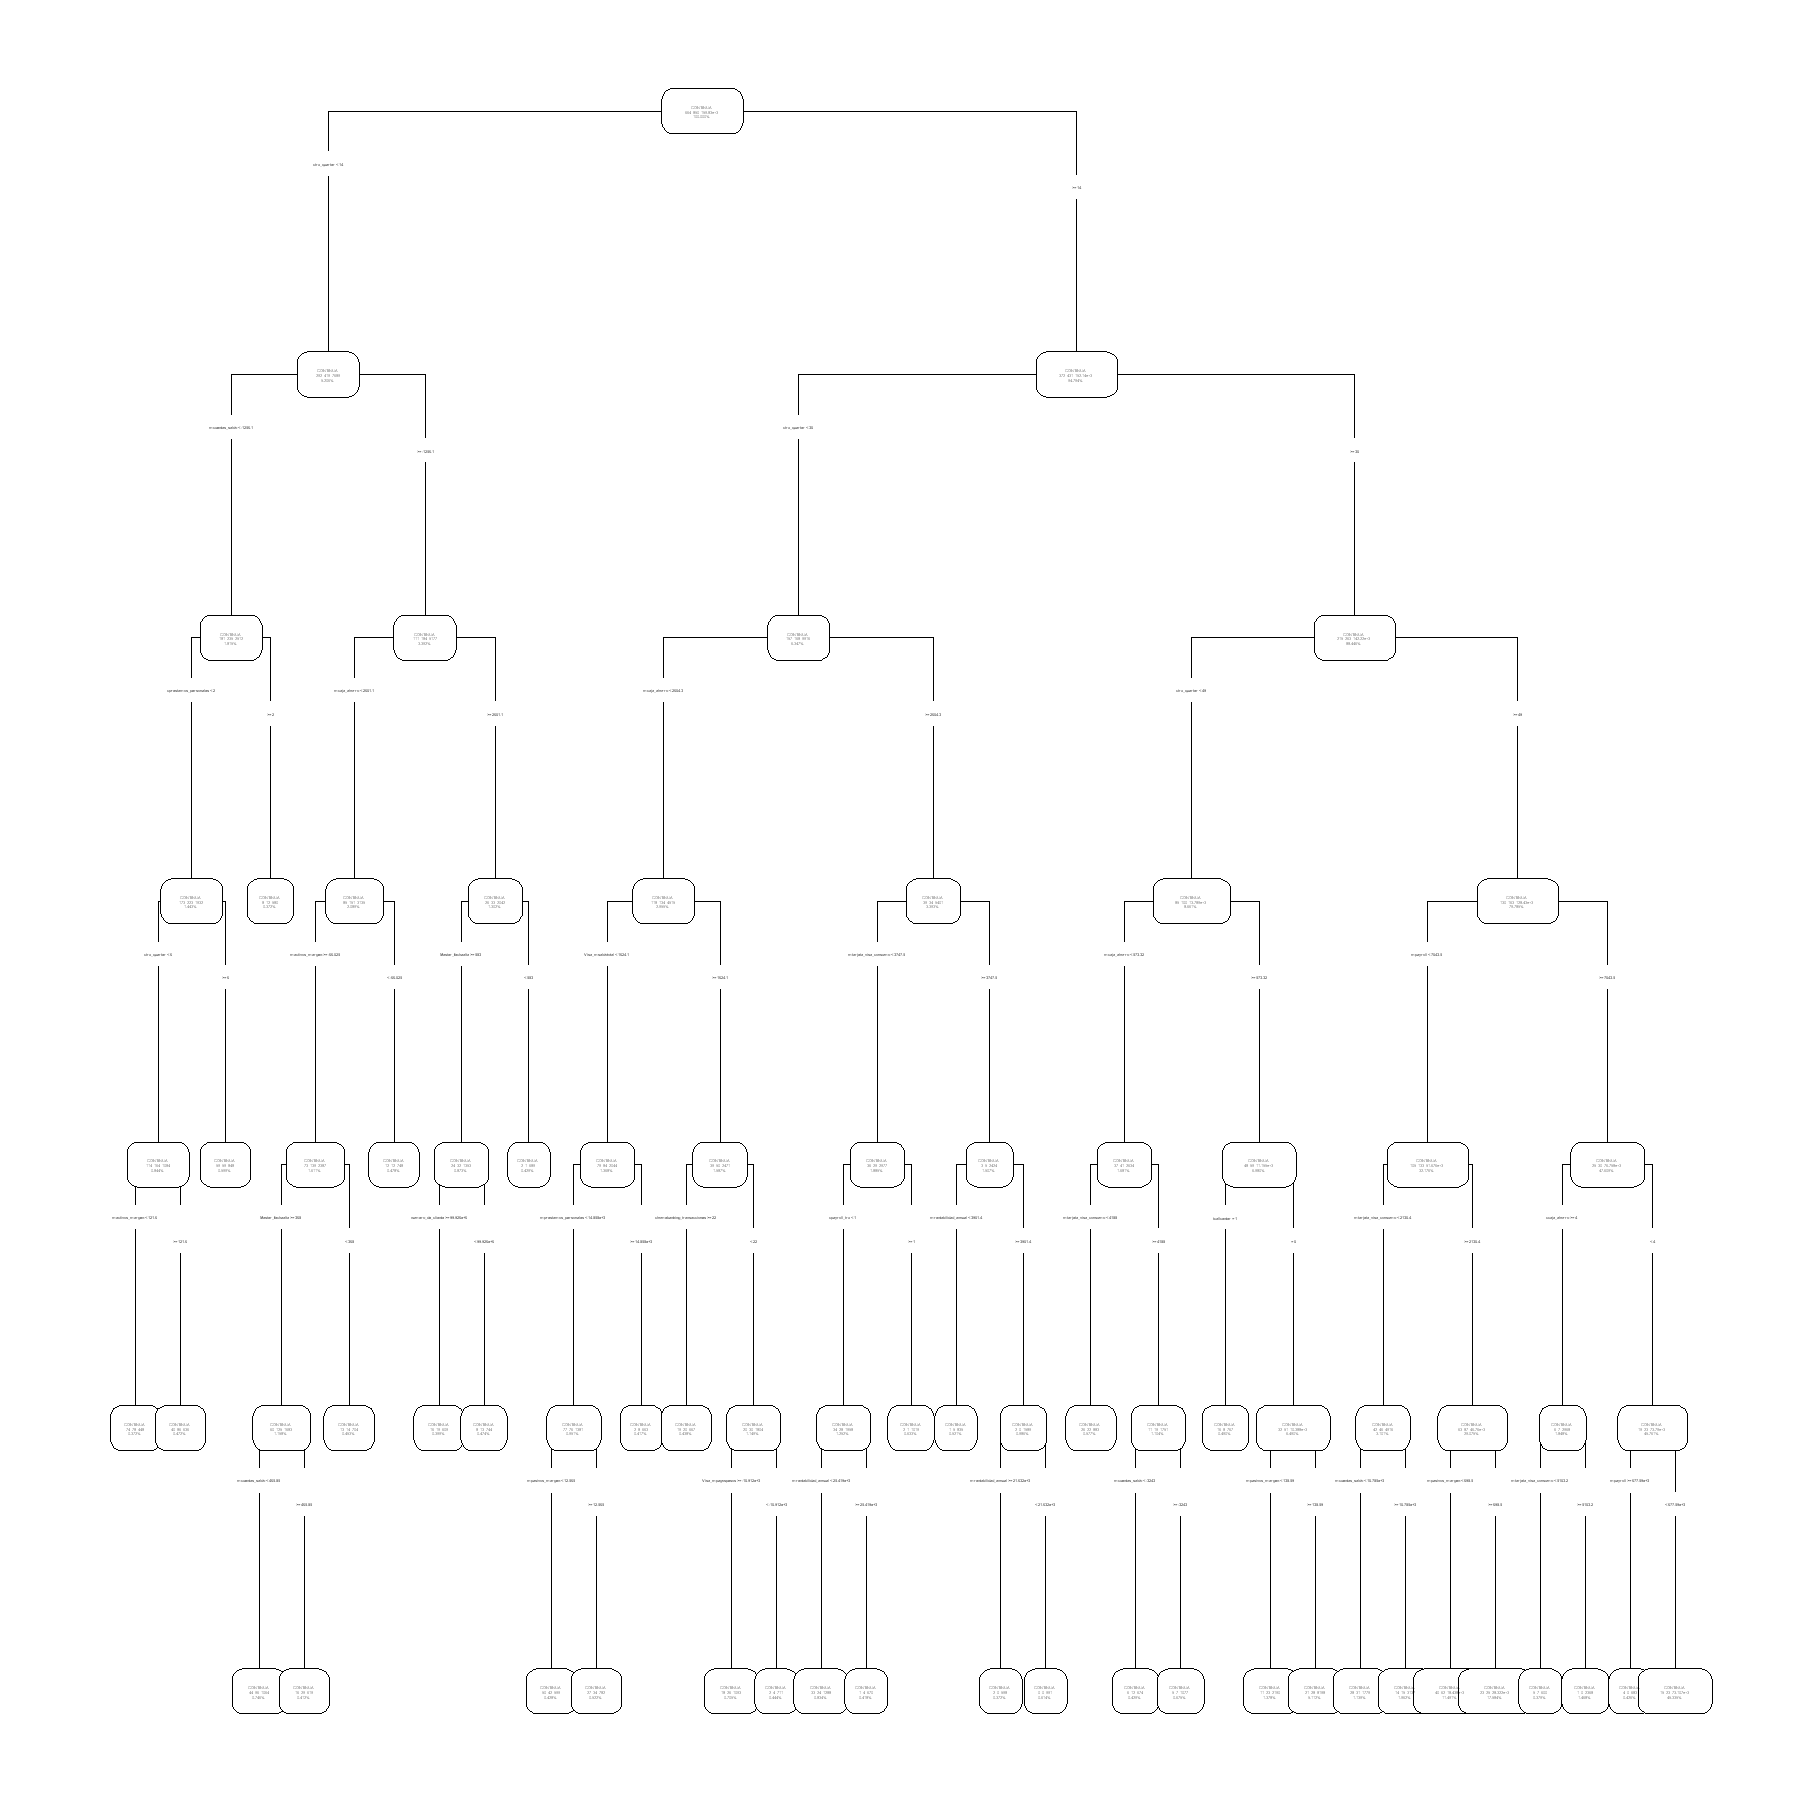

In [99]:
#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

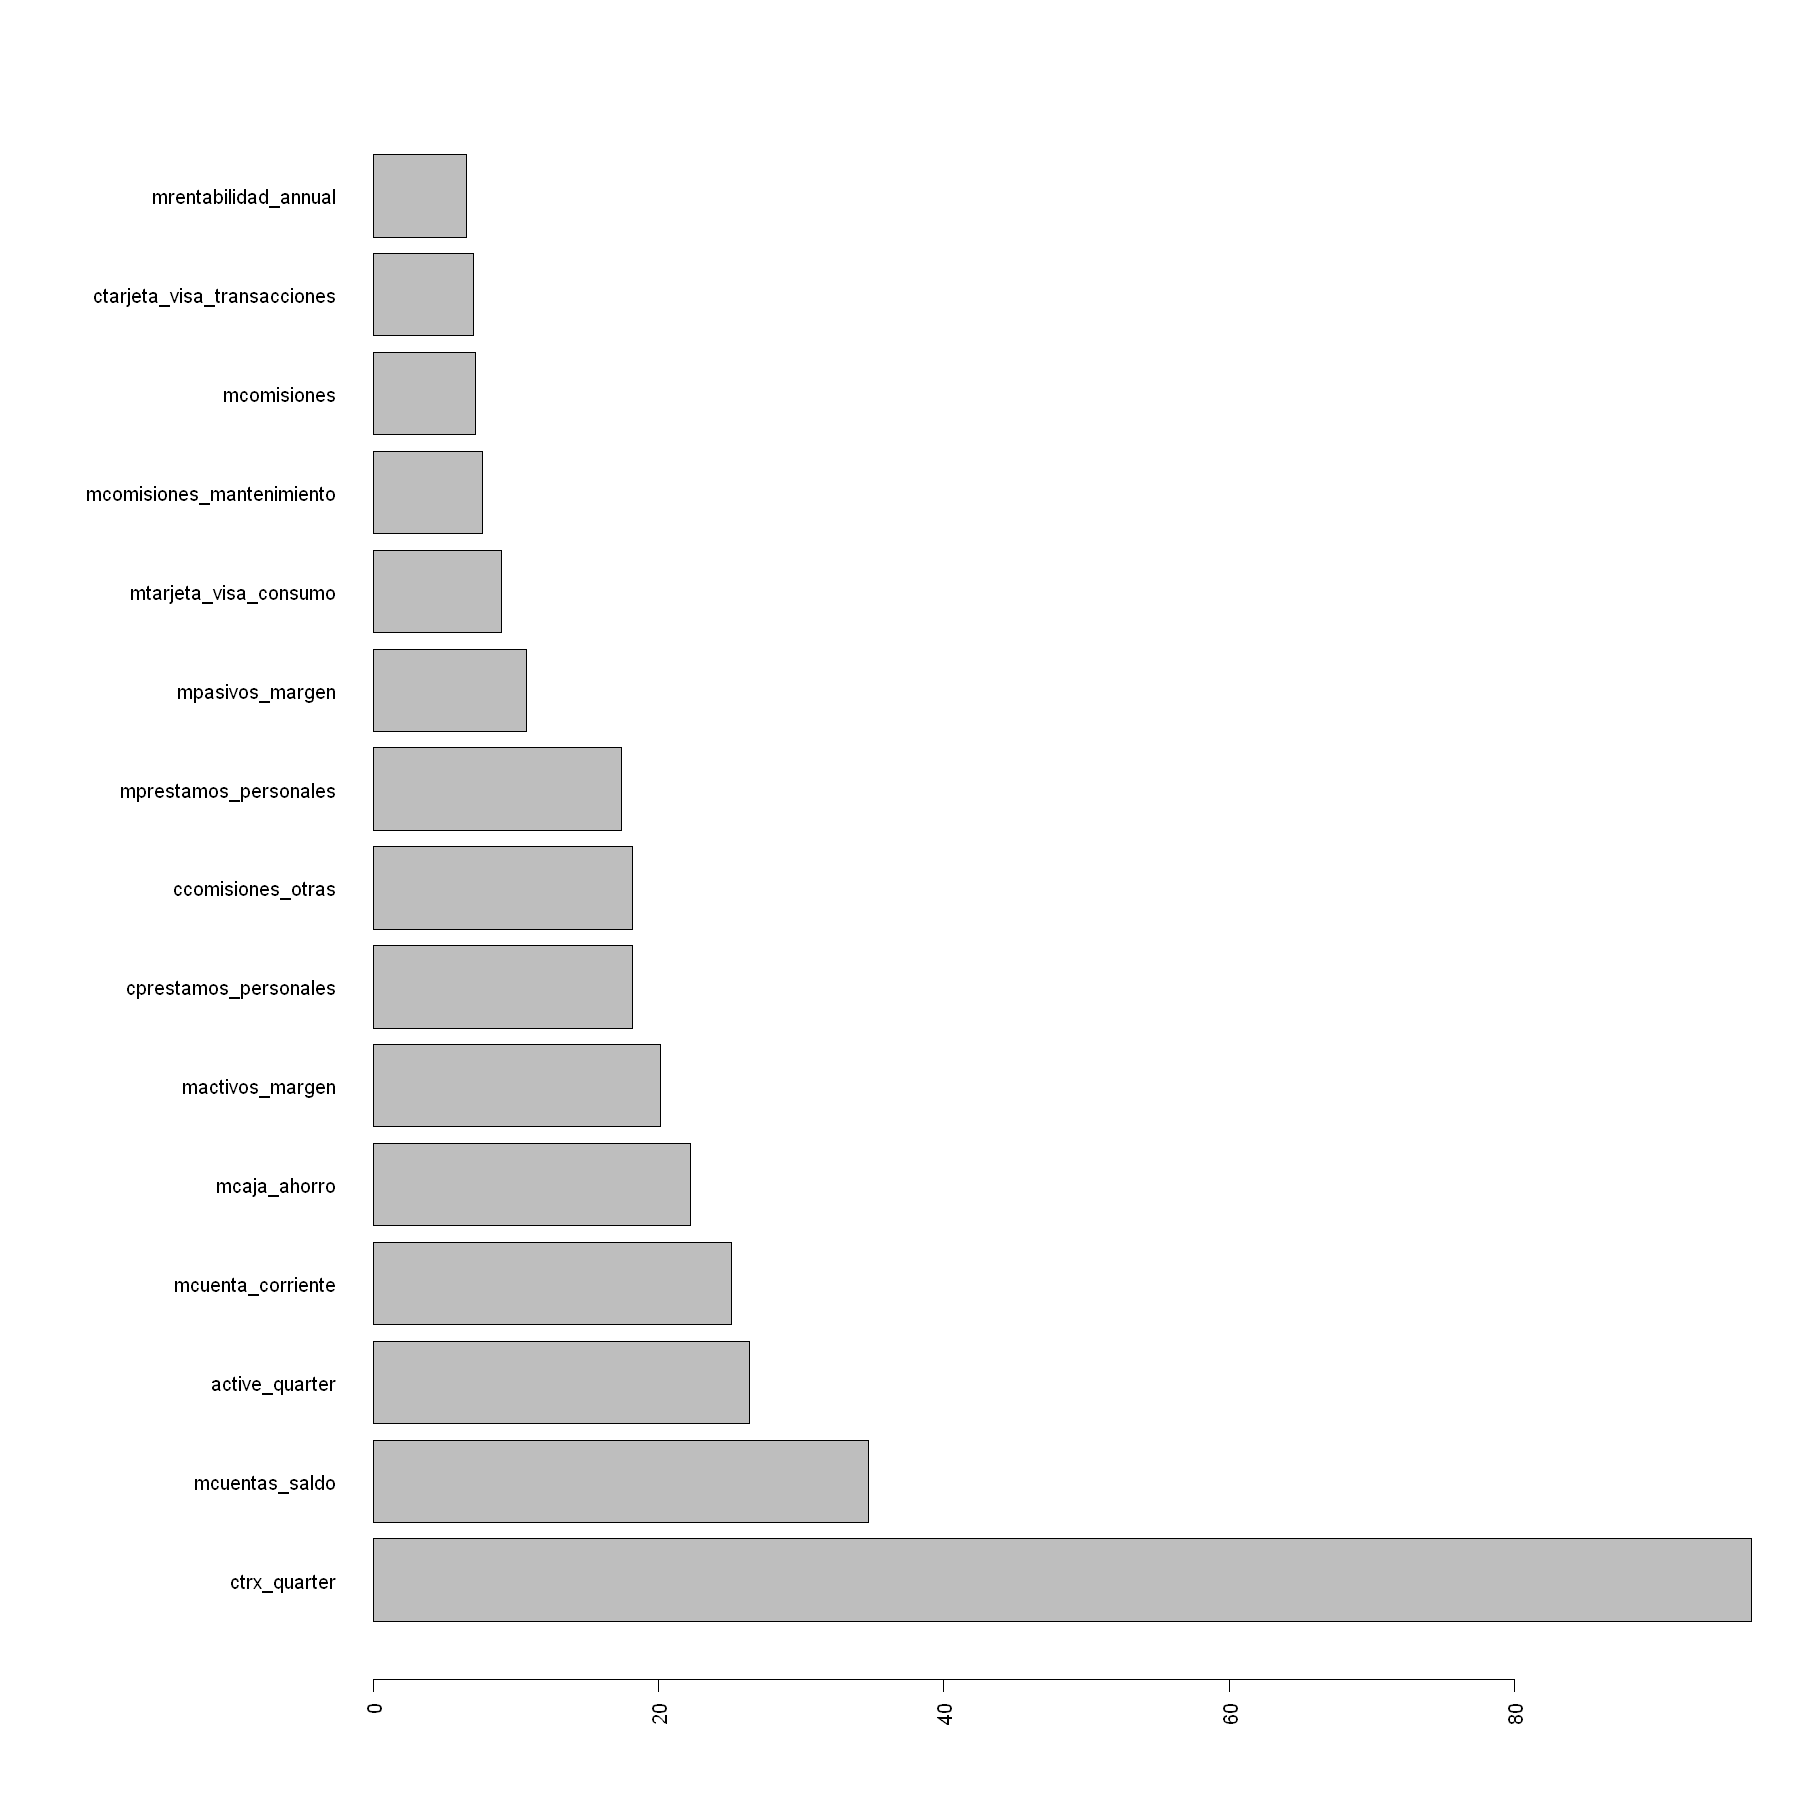

In [100]:
par(las=2,mar=c(5,15,4,2))
barplot(sort(modelo$variable.importance,decreasing=TRUE)[1:15],horiz=TRUE)